In [1]:
import numpy as np
import torch

import time
import pandas as pd

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
data_path = f"data/north_kensington/max_air_polution"

years = [f"20{i}" for i in range(13, 24)]
titles = {
    "nitrogen_dioxide": "Nitrogen dioxide: $\mathrm{NO}_2$",
    "ozone": "Ozone: $\mathrm{O}_3$",
    "sulphur_dioxide": "Sulphur dioxide: $\mathrm{SO}_2$",
}

units = {
    "nitrogen_dioxide": "$\mu g/m^{3}$",
    "ozone": "$\mu g/m^{3}$",
    "sulphur_dioxide": "$\mu g/m^{3}$",
}

ordered_pollutants = [
    "nitrogen_dioxide",
    "ozone",
    "sulphur_dioxide",
]

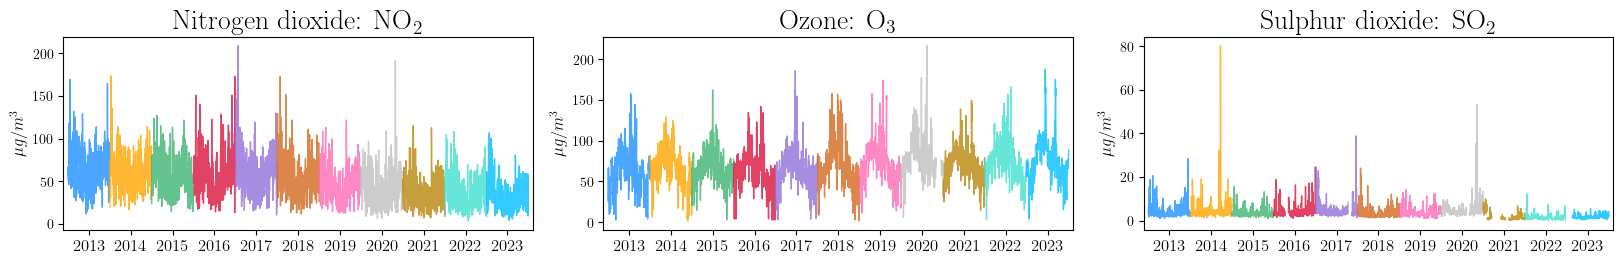

In [3]:
num_rows = 1
num_cols = 3

colors = [
    "dodgerblue",
    "orange",
    "mediumseagreen",
    "crimson",
    "mediumpurple",
    "chocolate",
    "hotpink",
    "silver",
    "darkgoldenrod",
    "turquoise",
    "deepskyblue",
]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 2.5))
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.5
)

current_count = 0
for j, year in enumerate(years):
    df = pd.read_csv(f"{data_path}_{year}.csv")
    t = df["day"].values + current_count
    current_count = t[-1]

    for i, pollutant in enumerate(ordered_pollutants):
        plt.subplot(num_rows, num_cols, i + 1)
        values = df[pollutant].values
        plt.plot(t, values, alpha=0.8, linewidth=1, label=year, color=colors[j])

for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index < 5:
            pollutant = ordered_pollutants[index]
            plt.subplot(num_rows, num_cols, index + 1)
            plt.yticks(fontsize=10)
            plt.xlim([-40, current_count + 40])
            plt.title(titles[pollutant], fontsize=20)
            plt.xticks([183 + n * 365 for n in range(len(years))], years, fontsize=12)
            plt.ylabel(units[pollutant], fontsize=12)
        else:
            fig.delaxes(axes[i][j])

plt.show()

In [4]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 0
grid_length = 128
num_points = grid_length * grid_length
output_dim = 2
nadir = torch.zeros(output_dim, **tkwargs)

In [5]:
bounds = {
    "nitrogen_dioxide": torch.tensor([0.0000, 120], **tkwargs),
    "ozone": torch.tensor([0.0000, 120], **tkwargs),
    "sulphur_dioxide": torch.tensor([0.0000, 6.5], **tkwargs),
}

In [6]:
all_Xs = {}
all_domination_probabilities = {}
start_time = time.time()
for i, p1 in enumerate(ordered_pollutants):
    for j, p2 in enumerate(ordered_pollutants):
        loop_time = time.time()
        if i < j:
            t1 = torch.linspace(bounds[p1][0], bounds[p1][1], grid_length, **tkwargs)
            t2 = torch.linspace(bounds[p2][0], bounds[p2][1], grid_length, **tkwargs)
            X1, X2 = torch.meshgrid(t1, t2, indexing="xy")

            domination_probabilities = {}

            for year in years:
                df = pd.read_csv(f"{data_path}_{year}.csv")
                num_samples = len(df.values)

                # Find active set of indices.
                index_set = []
                for n in range(num_samples):
                    is_row_nan = df.loc[n].isnull()
                    if not is_row_nan[p1] and not is_row_nan[p2]:
                        index_set.append(n)

                length_ratios = torch.zeros(
                    len(index_set), grid_length, grid_length, **tkwargs
                )

                for a in range(grid_length):
                    weights = torch.column_stack([X1[a, :], X2[a, :]]) - nadir
                    s_fn = LengthScalarization(
                        weights=weights + 0.00001, ref_points=nadir
                    )

                    for b, n in enumerate(index_set):
                        Y_n = torch.tensor([df[p1][n], df[p2][n]], **tkwargs)
                        length_ratios[b, a, :] = s_fn(Y_n).max(dim=0).values

                domination_probabilities[year] = (
                    (length_ratios >= 1).double().mean(dim=0)
                )

            all_domination_probabilities[f"{p1}_and_{p2}"] = domination_probabilities
            all_Xs[f"{p1}_and_{p2}"] = [X1, X2]

        else:
            continue
        print(
            f"p1={p1},p2={p2},loop_time={time.time()-loop_time},time_taken={time.time()-start_time}"
        )

p1=nitrogen_dioxide,p2=ozone,loop_time=81.86095833778381,time_taken=81.86095833778381
p1=nitrogen_dioxide,p2=sulphur_dioxide,loop_time=76.84157156944275,time_taken=158.70252990722656
p1=ozone,p2=sulphur_dioxide,loop_time=57.3870108127594,time_taken=216.08954071998596


In [7]:
short_titles = {
    "nitrogen_dioxide": "$\mathrm{NO}_2$",
    "ozone": "$\mathrm{O}_3$",
    "sulphur_dioxide": "$\mathrm{SO}_2$",
}

In [8]:
get_p1_and_p2 = {}

count = 0
for i, p1 in enumerate(ordered_pollutants):
    for j, p2 in enumerate(ordered_pollutants):
        if i < j:
            get_p1_and_p2[count] = [p1, p2]
            count += 1
        else:
            continue

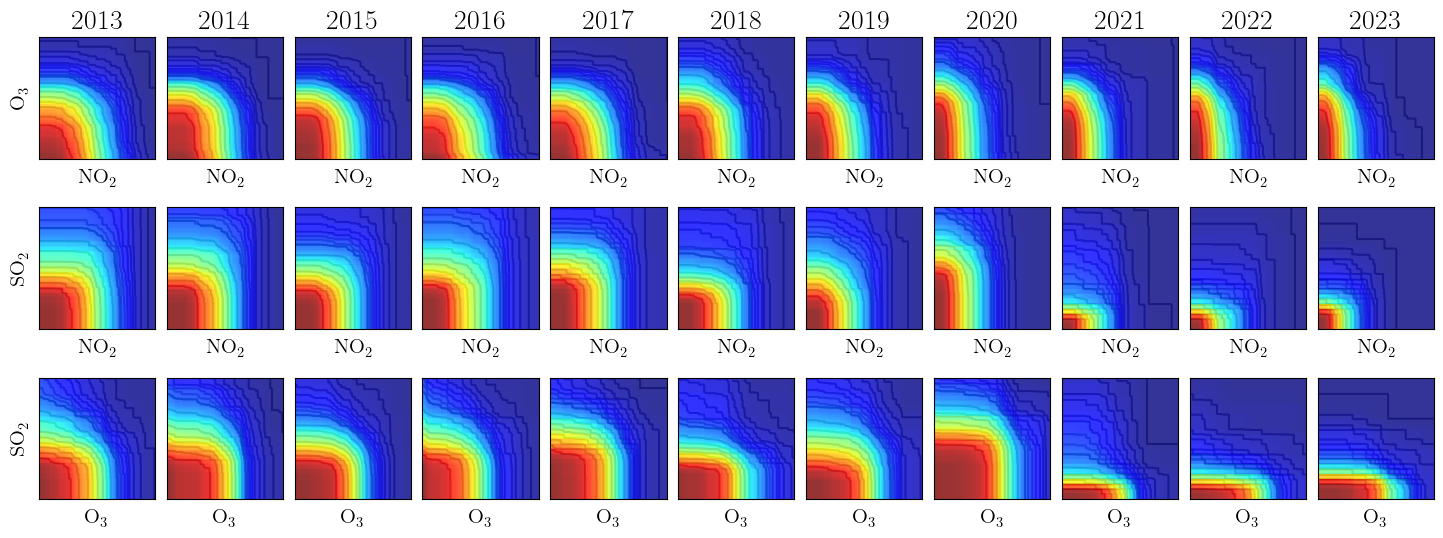

In [9]:
num_rows = int(len(ordered_pollutants) * (len(ordered_pollutants) - 1) / 2)
num_cols = len(years)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 2 * num_rows))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.4
)


for row in range(num_rows):
    for col, y in enumerate(years):
        index = row * num_cols + col
        p1, p2 = get_p1_and_p2[row]

        plt.subplot(num_rows, num_cols, index + 1)

        X1, X2 = all_Xs[f"{p1}_and_{p2}"]
        dom_prob = all_domination_probabilities[f"{p1}_and_{p2}"][y]

        plt.contour(
            X1,
            X2,
            dom_prob,
            alpha=0.5,
            levels=np.concatenate(
                [np.linspace(0, 0.2 - 0.001, 10), np.linspace(0.2, 0.9, 9)]
            ),
            colors="k",
        )
        img = plt.imshow(
            dom_prob,
            extent=[bounds[p1][0], bounds[p1][1], bounds[p2][0], bounds[p2][1]],
            origin="lower",
            cmap="jet",
            alpha=0.8,
            vmin=0.0,
            vmax=1.0,
            aspect="auto",
            zorder=2,
        )

        plt.xticks([])
        plt.yticks([])

        plt.xlabel(short_titles[p1], fontsize=15)

        if row == 0:
            plt.title(y, fontsize=20)
        if col == 0:
            plt.ylabel(short_titles[p2], fontsize=15)

plt.show()

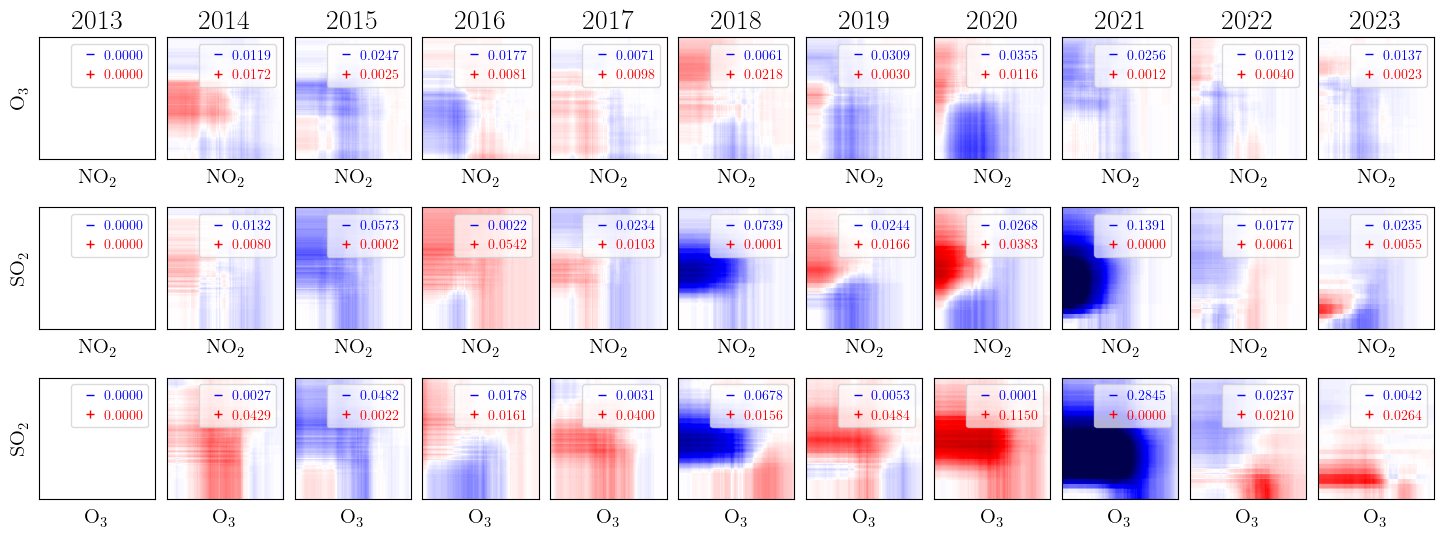

In [10]:
num_rows = int(len(ordered_pollutants) * (len(ordered_pollutants) - 1) / 2)
num_cols = len(years)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 2 * num_rows))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.4
)

for row in range(num_rows):
    for col, y in enumerate(years):
        index = row * num_cols + col
        p1, p2 = get_p1_and_p2[row]

        dom_probs = all_domination_probabilities[f"{p1}_and_{p2}"]
        X1, X2 = all_Xs[f"{p1}_and_{p2}"]

        plt.subplot(num_rows, num_cols, index + 1)

        if not y == "2013":
            dom_prob = dom_probs[y] - dom_probs[str(int(y) - 1)]
            plus = torch.mean(
                torch.maximum(dom_prob, torch.zeros(dom_prob.shape, **tkwargs))
            )
            minus = torch.mean(
                torch.maximum(-dom_prob, torch.zeros(dom_prob.shape, **tkwargs))
            )

            img = plt.imshow(
                dom_prob,
                extent=[bounds[p1][0], bounds[p1][1], bounds[p2][0], bounds[p2][1]],
                origin="lower",
                cmap="seismic",
                alpha=1,
                vmin=-0.5,
                vmax=0.5,
                aspect="auto",
                zorder=2,
            )
        else:
            plus = 0.0
            minus = 0.0

        blue_minus = mlines.Line2D(
            [],
            [],
            color="b",
            marker="_",
            linestyle="None",
            label=f"{minus:.4f}",
        )

        red_plus = mlines.Line2D(
            [],
            [],
            color="r",
            marker="+",
            linestyle="None",
            label=f"{plus:.4f}",
        )
        legend = axes[row, col].legend(
            handles=[
                (blue_minus),
                (red_plus),
            ],
            ncol=1,
            fontsize=10,
            loc="upper right",
            facecolor="w",
            framealpha=0.7,
            handletextpad=0,
        )

        for h, t in zip(legend.legendHandles, legend.get_texts()):
            t.set_color(h._get_markerfacecolor()[0])

        plt.xticks([])
        plt.yticks([])

        plt.xlabel(short_titles[p1], fontsize=15)

        if row == 0:
            plt.title(y, fontsize=20)
        if col == 0:
            plt.ylabel(short_titles[p2], fontsize=15)

plt.show()